## Notebook to research diabetes onset 


e) Matched Controls Diabetes Onset Curve(Blue 3)

   1. Get all the canary patients who have their CC_DIABETES flag equals 0
   on their registered date.
   
       1. Pick a matching algorithm
   2. Create the macthed population
       2. For each canary patient let their registration month be i
       2. Find N(for example 50)  control patients to match this canary patient from the pmpm 
       patients on month i who have CC_DIABETES = 0 on month i. For example the N patients should have the same age 
       and then be the nearest neighbors according to other features(log costs, cc codes etc).
       2. Set the index date for these pmpm controls patients to be month i.
       2. This forms a matched set of roughly 30 times the number of canary patients and each control has an index date.
   
   3. Compute Onset of Diabetes for month i: 
       3. Get all the matched controls with index date prior to month i.
       3. For Month i we define the total number of Diabetes Onsets(DO) as the number of subjects from e.3 that had
        the flag CC_DIABETES = 1 at Month (i) and CC_DIABETES = 0 at Month (i-1) (Note these patients must be in pmpm on both months).
       3. S is the total number of matched controls included in the pmpm both in month i and month i-1 
       3. For Month i we define the diabetes onset rate(DOR) as:
             DOR =  DO/S*1000

       3. Suggestion: Remove from  S the subjects that  have the flag CC_DIABETES = 1 at month i-1

   

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext Cython
%reload_ext Cython

In [2]:
import pandas as pd
import numpy as np
import time
import datetime as dt
from pathlib import Path
import time
#custom
from data_functions import make_date_to_MYR
from diabetes_onset import(process_canary,
get_tc, in_canary, diabet_onset, not_first_month_diabetes, 
                           match_data_per_month, 
                           filter_first_month_diabetes,
                           matched_population, 
                           propensity_func,
                           nearest_neighbor_func, 
                           random_matching_func)

from tqdm import tqdm
from sklearn.neighbors import NearestNeighbors

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
np.random.seed(seed = 0)

### Load Pmpm Canary data

In [3]:
%%time
canary_p = '../../temp/CANARY.p'
pmpm_p = '../../temp/PMPM.p'

canary = pd.read_pickle(canary_p)
pmpm = pd.read_pickle(pmpm_p)

#drop pmpm duplicates
pmpm.drop_duplicates(subset = ['PERS_ID', 'MYR'], inplace = True)
canary.drop_duplicates(subset = ['PERS_ID'], inplace = True)

CPU times: user 5.47 s, sys: 7.44 s, total: 12.9 s
Wall time: 12.9 s


### Process Canary, 
1. Drop register dates beyond pmpm max date
2. Transform register date to MYR
3. Keep only ids and MYR

### Get Controls and Treated

In [4]:
%%time
canary2 = process_canary(canary, pmpm.MYR.max())
treated, controls = get_tc(pmpm.copy(), canary2)

CPU times: user 8.21 s, sys: 6.93 s, total: 15.1 s
Wall time: 15.1 s


### Keep Canary Patients from their date of registeration and onwards which did not have CC_DIABETES flag on, on their date of registration

In [5]:
%%time
treated2 = in_canary(treated.copy(), canary2)
treated2 = filter_first_month_diabetes(treated2.copy())
treated2.drop(columns = ['IN_CANARY'], inplace = True)

CPU times: user 6.11 s, sys: 71.9 ms, total: 6.18 s
Wall time: 6.18 s


### Transform Data using NN

In [6]:
import tensorflow as tf
from tensorflow.keras import models, layers
import numpy as np, pandas as pd

model = models.load_model("./TF_Model", compile=False)

In [7]:
# def log_(x):
#     return np.log(x) if x>0 else 0
# treated2.ALLOW_AMT = treated2.ALLOW_AMT.apply(log_)
# controls.ALLOW_AMT = treated2.ALLOW_AMT.apply(log_)

In [8]:
treated2.head()

PERS_ID     MYR  MBR_GNDR  AGE_AT_MIDMONTH  ALLOW_AMT  CC_ADHD  CC_ALZHEIMER  CC_ALZHEIMER_PLUS  CC_AMI  CC_ANEMIA  CC_ANXIETY_DISORDER  CC_ARTHRITIS  CC_ASTHMA  CC_ATRIAL_FIB  CC_AUTISM  CC_BIPOLAR  CC_BPH  CC_BREAST_CANCER  CC_CATARACT  CC_CEREBRAL_PALSY  CC_CHRONIC_KIDNEY  CC_COLORECTAL_CANCER  CC_COPD  CC_CYSTIC_FIBROSIS  CC_DEPRESSION  CC_DEPRESSIVE_DISORDERS  CC_DEVELOP_DELAYS  CC_DIABETES  CC_DISAB_DX_CNT  CC_DX_CNT  CC_ENDOMETRIAL_CANCER  CC_EPILEPSY  CC_FIBROMYALGIA  CC_GLAUCOMA  CC_HEARING_IMPAIR  CC_HEART_FAILURE  CC_HEPATITIS_A  CC_HEPATITIS_B_ACUTE  CC_HEPATITIS_B_CHRONIC  CC_HEPATITIS_C_ACUTE  CC_HEPATITIS_C_CHRONIC  CC_HEPATITIS_C_UNSPECIFIED  CC_HEPATITIS_D  CC_HEPATITIS_E  CC_HEPATITIS_GEN  CC_HIP_FRACTURE  CC_HYPERLIPIDEMIA  CC_HYPERTENSION  CC_HYPOTHYROID  CC_INT_DISAB  CC_ISCHEMIC  CC_LEARN_DISAB  CC_LEUKEMIAS  CC_LIVER  CC_LUNG_CANCER  CC_MIGRAINE  CC_MOBILITY_IMPAIR  CC_MULTIPLE_SCLEROSIS  CC_MUSCULAR_DYSTROPHY  CC_OBESITY  CC_OSTEOPOROSIS  CC_PERIPHERAL  \
0  2738758  202003         0               65        351      0.0           0.0                0.0     0.0        0.0                  0.0           0.0        0.0            0.0        0.0         0.0     0.0               0.0          0.0                0.0                0.0                   0.0      0.0                 0.0            0.0                      0.0                0.0          0.0                0          3                    0.0          0.0              0.0          0.0                0.0               0.0             0.0                   0.0                     0.0                   0.0                     0.0                         0.0             0.0             0.0               0.0              0.0                1.0              1.0             1.0           0.0          0.0             0.0           0.0       0.0             0.0          0.0                 0.0                    0.0                    0.0         0.0              0.0            0.0   
1  2738758  201910         0               65        284      0.0           0.0                0.0     0.0        0.0                  0.0           0.0        0.0            0.0        0.0         0.0     0.0               0.0          0.0                0.0                0.0                   0.0      0.0                 0.0            0.0                      0.0                0.0          0.0                0          3                    0.0          0.0              0.0          0.0                0.0               0.0             0.0                   0.0                     0.0                   0.0                     0.0                         0.0             0.0             0.0               0.0              0.0                1.0              1.0             1.0           0.0          0.0             0.0           0.0       0.0             0.0          0.0                 0.0                    0.0                    0.0         0.0              0.0            0.0   
2  2738758  201807         0               63          0      0.0           0.0                0.0     0.0        0.0                  0.0           0.0        0.0            0.0        0.0         0.0     0.0               0.0          0.0                0.0                0.0                   0.0      0.0                 0.0            0.0                      0.0                0.0          0.0                0          3                    0.0          0.0              0.0          0.0                0.0               0.0             0.0                   0.0                     0.0                   0.0                     0.0                         0.0             0.0             0.0               0.0              0.0                1.0              1.0             1.0           0.0          0.0             0.0           0.0       0.0             0.0          0.0                 0.0                    0.0                    0.0         0.0              0.0            0.0   
3  2738758  202

In [9]:
treated2_trans_features = model.predict(treated2.loc[:,"MBR_GNDR":])
controls_trans_features = model.predict(controls.loc[:,"MBR_GNDR":])

In [10]:
latent_dim = 8
latent_col_labels = []
for i in range(latent_dim):
    latent_col_labels.append("x"+str(i+1))
treated2_trans_features = pd.DataFrame(treated2_trans_features, columns=latent_col_labels)
controls_trans_features = pd.DataFrame(controls_trans_features, columns=latent_col_labels)

In [11]:
treated2 = pd.concat([treated2[["PERS_ID", "MYR", "CC_DIABETES"]], treated2_trans_features], axis=1)
controls = pd.concat([controls[["PERS_ID", "MYR", "CC_DIABETES"]], controls_trans_features], axis=1)

### For each patient in the treated group in its registartion month find a population of matched controls in the same month by using 

In [12]:
%%time
columns_to_match = latent_col_labels

propensity_func_args = {'match_on':columns_to_match, 'neighbors_per_treated': 20}
matched, matched_data = matched_population(treated2.copy(), 
                                           controls.copy(),
                                           propensity_func, 
                                           propensity_func_args)

Mathcing Function: propensity_func


Propensity Score Matching...fitting model


/usr/local/lib64/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib64/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Creating Matched Set...


1459it [27:28,  1.13s/it]


CPU times: user 23min 50s, sys: 6min 14s, total: 30min 5s
Wall time: 30min 3s


In [13]:
random_matching_func_args = {'neighbors_per_treated': 100}
random_controls = matched_population(treated2.copy(), 
                                       controls.copy(),
                                       random_matching_func, 
                                       random_matching_func_args)

Mathcing Function: random_matching_func


### Run the Diabetes onset Function

In [14]:
%%time
con_onset = diabet_onset(matched_data.copy(), 'Diabetes_Con')
treated_onset = diabet_onset(treated2.copy(), 'Diabetes_Tr')
pmpm2 = filter_first_month_diabetes(pmpm.copy())
pmpm_onset = diabet_onset(pmpm2, 'Diabetes_PM')

CPU times: user 4min 54s, sys: 35.8 s, total: 5min 30s
Wall time: 5min 28s


In [15]:
random_onset = diabet_onset(random_controls.copy(), 'Diabetes_Rnd')

In [16]:
con_onset2 = con_onset.rename(columns = {'Sample': 'Sample_Con', 'Per_1000':'Per_1000_Con'})
treated_onset2 = treated_onset.rename(columns = {'Sample': 'Sample_Tr', 'Per_1000':'Per_1000_Tr'})
pmpm_onset2 = pmpm_onset.rename(columns = {'Sample': 'Sample_PM', 'Per_1000':'Per_1000_PM'})

In [17]:
random_onset2 = random_onset.rename(columns = {'Sample': 'Sample_PM', 'Per_1000':'Per_1000_PM'})
joint = pd.concat((con_onset2, treated_onset2, pmpm_onset2, random_onset2), axis = 1)

### Diabetes Onset Per Month

1. **_Con : For Matched Controls Population**
2.  **_Tr : For Canary Treated Population**
3. **_PM : For the whole PMPM Population**
4. **_Rnd: For a Random Matching**

In [18]:
joint.describe().loc[['mean', 'std']]

Sample_Con  Diabetes_Con  Per_1000_Con   Sample_Tr  Diabetes_Tr  Per_1000_Tr      Sample_PM  Diabetes_PM  Per_1000_PM    Sample_PM  Diabetes_Rnd  Per_1000_PM
mean  7391.050000     13.300000      1.645658  439.425000     0.875000     1.403660  142435.020408   276.795918     1.947999  30522.30000     54.500000     2.006076
std   7053.401329     13.664853      0.992228  431.159016     1.264658     2.566655   13586.501014    44.652818     0.280876  27389.14942     48.724237     1.580962

In [19]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-dark')

/home/nneehal/.local/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [20]:
joint2 = pd.concat((con_onset, treated_onset, pmpm_onset, random_onset), axis = 1)
jointcon = joint2.Per_1000.iloc[1:, 0].reset_index()
jointTr = joint2.Per_1000.iloc[1:, 1].reset_index()
jointpmpm = joint2.Per_1000.iloc[1:, 2].reset_index()
jointrandom = joint2.Per_1000.iloc[1:, 3].reset_index()


**Plot Top Left**: $f(x)$ = Onset Per 1000 per month </br>
**Plot Top Right and Bottom Left**: $F(x) = \int_0^x f(y)dy$ Cumulative sum of the rates

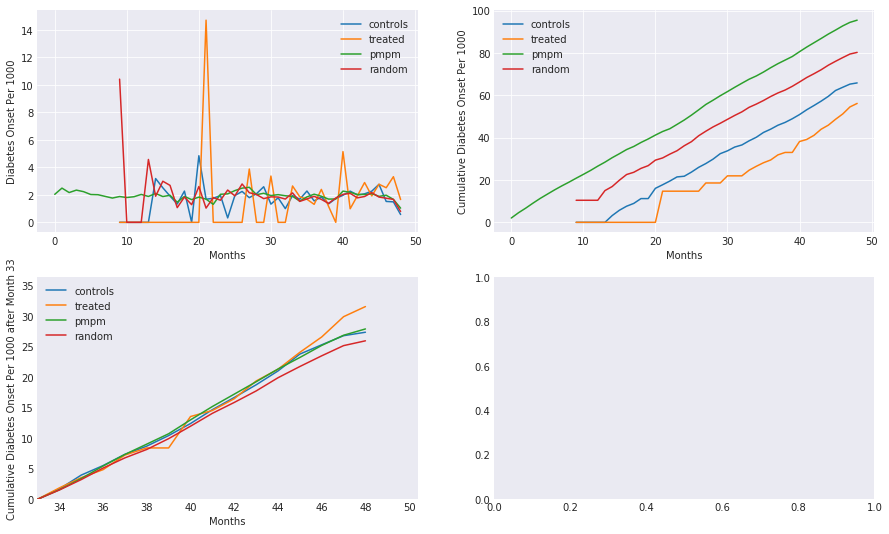

In [21]:
from diabetes_onset_plotter import plot_onset, plot_onset2
names = ['controls', 'treated', 'pmpm', 'random']
f, ax = plot_onset2(jointcon, jointTr, jointpmpm, jointrandom, names = names)
plt.show()

In [23]:
columns_to_match

['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8']

In [28]:
try:
    pmpm2.MBR_GNDR.replace(to_replace = {'F':0, 'M':1}, inplace = True)
except:
    pass

tr_desc = treated2[columns_to_match].describe().loc[['mean']]
#tr_desc.index = pd.MultiIndex.from_product([['Treated'], tr_desc.index])
tr_desc = tr_desc.T

con_desc = matched_data[columns_to_match].describe().loc[['mean']]
#con_desc.index = pd.MultiIndex.from_product([['Matched'], con_desc.index])
con_desc = con_desc.T

# pmpm_desc = pmpm2[columns_to_match].describe().loc[['mean']]
# #pmpm_desc.index = pd.MultiIndex.from_product([['PMPM'], pmpm_desc.index])
# pmpm_desc = pmpm_desc.T

random_desc = random_controls[columns_to_match].describe().loc[['mean']]
#pmpm_desc.index = pd.MultiIndex.from_product([['PMPM'], pmpm_desc.index])
random_desc = random_desc.T

alli = pd.concat((tr_desc, con_desc, random_desc), axis = 1, keys = ['TREATED', 'MATCHED', 'RANDOM'] )

In [29]:
alli

TREATED     MATCHED      RANDOM
          mean        mean        mean
x1  206.574905  214.598160  204.177780
x2    6.536012    6.763098    6.851520
x3    1.129756    1.164421    1.218850
x4   -0.795386   -0.806372   -0.757714
x5    2.813029    2.928279    2.995339
x6   -2.606989   -2.573286   -2.509822
x7    3.259648    3.321872    3.364218
x8    0.794555    0.948834    0.892960

In [27]:
random_controls.shape